<a href="https://colab.research.google.com/github/eduardalexandrut/llm-iq-test/blob/main/LLM_visual_iq_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM Visual IQ Testing

## Introduction

The purpouse of this notebook is to test several multimodal LLM on visual iq test.
Let's start by installing the following packages:
- `Transformers`: Provides pre-trained models and tokenizers for NLP and multimodal tasks. We’ll use it to load models and preprocess text and images for LLM testing.
- `PIL`: Handles image loading and manipulation. We’ll use it to preprocess and display images in multimodal model evaluation.
- `Datasets`: Offers easy access to standardized datasets from the Hugging Face Hub. We’ll use it to load datasets for training and evaluating models.

In [1]:
!pip install -U git+https://github.com/huggingface/transformers
!pip install PIL
!pip install datasets

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-1ic2lniw
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-1ic2lniw
  Resolved https://github.com/huggingface/transformers to commit 3a8eb74668e9c2cc563b2f5c62fac174797063e0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.47.0.dev0-py3-none-any.whl size=10101071 sha256=5b47c51c63b6dec42eb0f6a25a5f2789e618d561150de1aee4b399b3f120756f
  Stored in directory: /tmp/pip-ephem-wheel-cache-squ5im2y/wheels/c0/14/d6/6c9a5582d2ac191ec0a483be151a4495fe1eb2a6706ca49f1b
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.2
    Uninstalling transformers-4.46.2:
      Successfully uninstalled transformers-4.46.2
ERROR: Could not find a version that sa

Now let's import the necessary modules from these packages:
- `AutoTokenizer`: Responsible for converting input text into tokens that the model can process, adapting to the specific tokenization requirements of the model.
- `AutoProcessor`: Used to preprocess inputs, often across modalities like text and image, ensuring compatibility with multimodal models.
- `Image`: Used for opening, manipulating, and displaying image files, essential for handling image data in multimodal model testing.
- `AutoModelForCausalLM`: Provides the pre-trained language model for generating predictions in a causal (autoregressive) manner, typically for text generation tasks.
- `requests`: A module for sending HTTP requests, often used to fetch data from APIs or retrieve images and other resources over the internet.
-`load_datasets`: Loads datasets from the Hugging Face Hub or local files, enabling access to standardized datasets for model training and evaluation.

In [17]:
from transformers import AutoTokenizer, AutoProcessor, AutoModelForCausalLM, set_seed, GenerationConfig
from PIL import Image
import requests
from datasets import load_dataset
import re
import json
import gc
import torch

In [3]:
set_seed(42)

## Dataset

Now we'll download `MENSA-visual-iq-test` from HuggingFace. This dataset contains several visual iq tests from MENSA. The dataset is made up of 3 subsets:

- MENSA Norway: 35 instances.
- MENSA Denmark: 38 instances.
- MENSA Sweden: 25 instances.

We'll use the `load_dataset` function that we've imported before to load the dataset:

In [4]:
dataset = load_dataset("eduardtoni/MENSA-visual-iq-test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/846 [00:00<?, ?B/s]

(…)-00000-of-00001-25c0febc1da39286.parquet:   0%|          | 0.00/5.12M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/98 [00:00<?, ? examples/s]

In [ ]:
dataset['train']

Dataset({
    features: ['question_id', 'question_path', 'question_img', 'difficulty', 'subset', 'correct_answer_img', 'correct_answer', 'choices_letter', 'choices_images', 'multiple_answer_img', 'multiple_answer_path', 'explanations'],
    num_rows: 98
})

Every entry in the dataset represents a question, and has the following features:

- `question_id`: Unique identifier.
- `question_path`: The path to the image representing the question.
- `question_img`: A PIL image of the question.
- `subset`: The subset of which the question is part of.
- `difficulty`: An integer between 1 and 3 representing the difficulty of the question.
- `correct_answer_img`: A PIL image of the correct answer image.
- `correct_answer`: The path to the correct answer image.
- `choiches_letter`: An array of characters with all the possible answers to a question (e.x. 'A', 'B', 'C',...)
- `choiches_images`: An array containing the paths to the images of all possible answers to a question.
- `multiple_answer_img`: A PIL image that contains all the possible answers to a question. Each one is labeled with corresponfing letter.
- `multiple_answer_path`: The path to the multiple answer image.
- `explanations`: An array containing different explanations for the reason why a specific answer is the correct one.

The dataset has 98 instances in total.

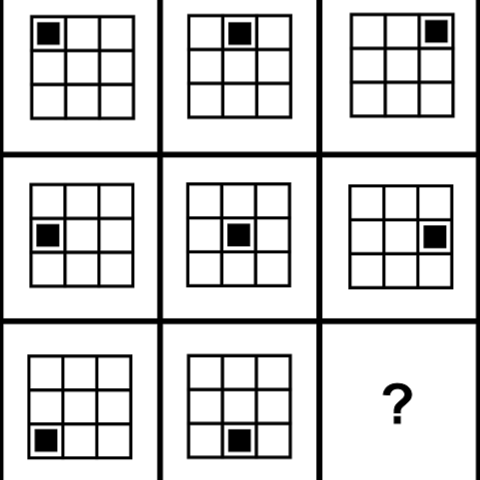

In [ ]:
dataset['train'][0]['question_img']

This is a question image.

The following image is the correct answer to the previous question.

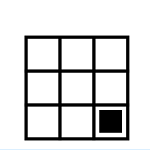

In [ ]:
dataset['train'][0]['correct_answer_img']

The following image is the multiple answer image of the previous question, containing all the possible labeled answers.

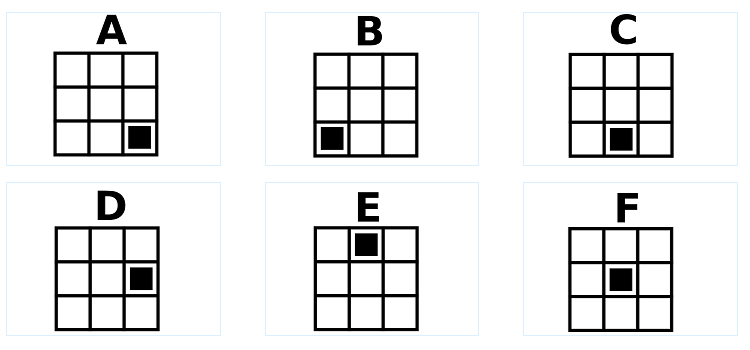

In [ ]:
dataset['train'][0]['multiple_answer_img']

## Helper Functions

Next, we'll define some functions that will help us dealing with the work load.

The first function we define is `convert_answer_to_json`. This function will take as input the answer generated by a model, and extract the json answer and create a json object.

In [5]:
def convert_answer_to_json(answer):
    assistant = '\nassistant\n'
    parts = answer.split(assistant, 1)
    res = parts[1].strip() if len(parts) > 1 else None

    # Remove Markdown-style ```json``` delimiters if present
    cleaned_string = re.sub(r"```json|```", "", res).strip() if res else None

    if cleaned_string:
        try:
            json_object = json.loads(cleaned_string)  # Parse the cleaned string

            # Clean the explanation field
            if "explanation" in json_object:
                json_object["explanation"] = extract_and_clean_explanation(cleaned_string)

            return json_object
        except json.JSONDecodeError as e:
            print(f"JSON decode error: {e}")
            print(res)
            return None
    else:
        return None

We ask the model to return the answer to the question and an explanation. The answer must be formatted in the following json structure:

{

  "answer": "The letter corresponding to the answer",

  "explanation":"The reason why the model has chosen this answer as the correct one."

}

Sometimes, even with prompt enginering, the models generate an answer that is not correctly formated and breaks the json structure, by intoducing double quotes`""` inside the `explanation` field. The purpouse of the following function `extract_and_clean_explanation` is to clean up the `explanation` field by replacing double quotes with single quotes `''`.

In [6]:
def extract_answer(text):
    # Extract the answer field
    answer_start = text.find('"answer": "') + len('"answer": "')
    answer_end = text.find('"', answer_start)
    answer_content = text[answer_start:answer_end]

    # Clean the answer content (if needed)
    cleaned_answer = answer_content.strip()

    # Extract and clean the explanation content
    cleaned_explanation = extract_and_clean_explanation(text)

    # Return a dictionary with the extracted and cleaned fields
    return {
        "answer": cleaned_answer,
        "explanation": cleaned_explanation
    }

In [7]:
def extract_and_clean_explanation(text):
    # Locate the start of the explanation content
    start = text.find('explanation": "') + len('explanation": "')

    # Find the end quote of the explanation text
    end = text.find('"', start)

    # Extract the content between the quotes
    explanation_content = text[start:end]

    # Remove all double quotes from the explanation content
    cleaned_explanation = explanation_content.replace('"', '')

    return cleaned_explanation

We define a function called `test_split()`. This function takes as input the following arguments:
- `dataset`: The dataset on which the model will be tested.
- `subset`: The subset of the dataset(Norway, Sweden, Denmark).
- `start`: The start index.
- `end`: The end index.
- `model`: The model we will test.
- `prompt`: The prompt that will be given to the model.
- `processor`: The processor of the model.

The function the returns an array of answers as json objects.

In [20]:
def test_split(dataset, model=None, prompt=None, processor=None, **params):
    # Extract arguments from kwargs
    subset = params.get('subset', 'MENSA Norway')
    start = params.get('start', 0)
    end = params.get('end', None)
    decoding_strategy = params.get('decoding_strategy', 'greedy')
    top_p = params.get('top_p', 0.9)
    num_beams = params.get('num_beams', 2)
    max_new_tokens = params.get('max_new_tokens', 512)

    # Filter the dataset subset
    if subset is not None:
        print(f"Subset: {subset}")
        dataset_subset = dataset['train'].filter(lambda x: x['subset'] == subset)
    else:
        dataset_subset = dataset['train']

    # Determine the range of indices
    dataset_length = len(dataset_subset)
    end = end or dataset_length
    end = min(end, dataset_length)

    # Slice the filtered subset
    dataset_subset = dataset_subset.select(range(start, end))
    print(f"Testing on {len(dataset_subset)} examples.")

    answers = []

    for i, example in enumerate(dataset_subset):
        question_img = example['question_img']
        answer_img = example['multiple_answer_img']

        # Apply prompt dynamically if needed
        if prompt == 'difficulty_prompt':
            prompt = get_difficulty_prompt(prompt, example['difficulty'])

        # Apply the provided prompt template
        text_prompt = processor.apply_chat_template(prompt, add_generation_prompt=True)

        # Prepare inputs
        inputs = processor(
            text=text_prompt,
            images=[question_img, answer_img],
            return_tensors="pt"
        )

        # Generate output from the model
        if decoding_strategy == 'greedy':
            output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
        elif decoding_strategy == 'top_p':
            output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens, top_p=top_p)
        elif decoding_strategy == 'beam_search':
            output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens, num_beams=num_beams)
        else:
            print(f"Invalid decoding strategy '{decoding_strategy}'. Using default greedy strategy.")
            output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)

        # Decode output text
        output_text = processor.batch_decode(output_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)

        # Convert output to answer dicts
        answer = extract_answer(output_text[0])
        if answer:
            answer['question_id'] = example["question_id"]
            answers.append(answer)
        else:
            print(f"No valid JSON found in the generated text from question {example['question_id']}.")

    return answers


The following `get_score` function gets the answers given by a LLM and returns a tuple made of the number of correct answers, the percentage of correct answers and the iq score obtained.

In [9]:
def get_score(answers, dataset):
  num_correct_answers = sum(answer['answer'] == dataset['train'][answer['question_id']]['correct_answer'] for answer in answers)
  percentage_correct_answers = (num_correct_answers/len(answers)) * 100
  iq_score = 0
  return (num_correct_answers, percentage_correct_answers, iq_score)

In [10]:
def get_difficulty_prompt(prompt, difficulty):
    # Replace placeholder with the actual difficulty value
    updated_prompt = prompt.copy()  # Create a copy to avoid mutation
    updated_prompt[1]['content'][0]['text'] = updated_prompt[1]['content'][0]['text'].format(difficulty)
    return updated_prompt

The following `save_results` function will be used to save the result of a test inside a json file. The object will have the following attributes:
- `model`:
- `prompt`:
- `split`:
- `answers`:
- `correct_answers`:
- `percentage_score`:
- `iq_score`:

In [ ]:
def save_results(model, prompt, split, answers, correct_answers, percentage_score, iq_score):
  #Create json object representing a test.
  result = {
      'model': model,
      'prompt': prompt,
      'split': split,
      'answers': answers,
      'correct_answers': correct_answers,
      'percentage_score': percentage_score,
      'iq_score': iq_score
  }

  #Extract the name of the prompt used.
  prompt_name = next(prompt.keys())

  #Save result inside a json file.
  with open(f"/results/{model}/{prompt_name}.json", "w") as out_file:
    for ans in mensa_norway_answers:
      json_line = json.dumps(ans)
      out_file.write(json_line + "\n")
  return

## Prompts

One of the goals of this paper is to try different prompts and prompting techniques, in order to see how it affects the performance of a model. The following dictionary `prompt` contains all the different prompts we will test:

In [11]:
prompts = {
    'prompt_1': [
        {
            'role': 'system',
            'content': 'Please reason step by step'
        },
        {
            'role': 'user',
            'content': [
                {
                    'type': 'image',
                },
                {
                    'type': 'text',
                    'text': 'Analyze the previous image: a grid of images with one cell marked with the symbol ?. Identify any visual or logical patterns within rows and columns to understand what the missing cell should contain.'
                },
                {
                    'type': 'image',
                },
                {
                    'type': 'text',
                    'text': 'Analyze the previous image: This image shows all possible answer choices. Each choice has a unique drawing labeled with a letter above it, which you can select from to complete the missing cell in the first image based on the identified pattern.'
                },
                {
                    'type': 'text',
                    'text': 'Using the two images, determine the pattern in the first image and select the letter above the drawing in the second image that best completes the missing cell. Return your answer in the following JSON format: {"answer": your selected letter, "explanation": your reasoning here}. Do not use "" symbols within the explanation inside the json.'
                }
            ]
        }
    ],
    'prompt_2': [
        {
            'role': 'system',
            'content': 'Please reason step by step'
        },
        {
            'role': 'user',
            'content': [
                {
                    'type': 'image',
                },
                {
                    'type': 'text',
                    'text': 'Analyze the previous image: a grid of images with one cell marked with the symbol ?. Identify any visual or logical patterns within rows and columns to understand what the missing cell should contain.'
                },
                {
                    'type': 'image',
                },
                {
                    'type': 'text',
                    'text': 'Analyze the previous image: This image shows all possible answer choices. Each choice has a unique drawing labeled with a letter above it, which you can select from to complete the missing cell in the first image based on the identified pattern.'
                },
                {
                    'type': 'text',
                    'text': 'Using the two images, determine the pattern in the first image and select the letter above the drawing in the second image that best completes the missing cell. Return your answer in the following JSON format: {"answer": your selected letter}.'
                }
            ]
        }
    ],
    'prompt_3': [
        {
            'role': 'system',
            'content': 'Please reason step by step'
        },
        {
            'role': 'user',
            'content': [
                {
                    'type': 'image',
                },
                {
                    'type': 'text',
                    'text': 'Analyze carefully the previous image: its made up of a grid of 6 cells. Each cell has a drawing inside of it, except the last one which has a ? symbol. You goal is to analyze each cell and try to find a pattern along the columns, the rows and the diagonals, in order to understand what the missing cell should contain.'
                },
                {
                    'type': 'image',
                },
                {
                    'type': 'text',
                    'text': 'Analyze carefully the previous image: This image shows all possible answer choices. Each choice has a unique drawing and is labeled with a letter above it. Select the correct drawing to complete the previous grid based on the identified pattern.'
                },
                {
                    'type': 'text',
                    'text': 'Using the two images, determine the pattern in the first image and select the letter above the drawing in the second image that best completes the missing cell. Return your answer in the following JSON format: {"answer": your selected letter,"explanation": your reasoning here}. Do not use "" symbols within the explanation inside the json.'
                }
            ]
        }
    ],
    'analyst_prompt': [
        {'role': 'system', 'content': 'You are a methodical and detail-oriented analyst, tasked with meticulously examining complex IQ test patterns. Your responses must be precise, well-reasoned, and logical. Treat each question with the absolute seriousness.'},
        {'role': 'user', 'content': [
            {'type': 'image'},
            {'type': 'text', 'text': 'Inspect the previous image carefully. It is a grid with one cell marked as "?". Detect any consistent patterns across rows, columns an diagonals in order to find the replacement inside the missing cell.'},
            {'type': 'image'},
            {'type': 'text', 'text': 'Examine the image displaying answer choices, each marked with a letter. Deduce the most suitable choice based on the previously identified pattern.'},
            {'type': 'text', 'text': 'Submit your answer using the following JSON format, with thorough reasoning for your selection: {"answer": chosen letter, "explanation": reasoning}. Refrain from using extraneous symbols within the explanation.'}
        ]}

    ],
    'difficulty_prompt': [
        {'role': 'system', 'content': 'You will be given 2 images regarding a visual iq test. The first image is the question, while the second image contain several solutions, but only one is the correct answer. You will be given the difficulty of each question. The difficulty can be of value 1 (easy), 2 (medium), 3 (hard). The harder the question, the more careful you will have to be at analyzing the question image.'},
        {'role': 'user', 'content': [
            {'type':'text', 'text': 'Difficulty of the question: {}'},
            {'type': 'image'},
            {
                    'type': 'text',
                    'text': 'Analyze the previous image: a grid of images with one cell marked with the symbol ?. Identify any visual or logical patterns within rows,columns and diagonals to understand what the missing cell should contain.'
            },
            {'type': 'image'},
            {
                    'type': 'text',
                    'text': 'Analyze the previous image: This image shows all possible answer choices. Each choice has a unique drawing labeled with a letter above it, which you can select from to complete the missing cell in the first image based on the identified pattern.'
            },
            {
                    'type': 'text',
                    'text': 'Using the two images, determine the pattern in the first image and select the letter above the drawing in the second image that best completes the missing cell. Return your answer in the following JSON format: {"answer": your selected letter}.'
            }
        ]}
    ]
}

## QwenV2 2B

The first model we will test is Qwen2-VL-2B-Instruct.

In [12]:
from transformers import Qwen2VLForConditionalGeneration

Load Qwen2-VL-2B-Instruct model and encoder.

In [ ]:
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct",
    torch_dtype = "auto",
    device_map = "auto",
    trust_remote_code=True
)
processor = AutoProcessor.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct",
    trust_remote_code=True
)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.4k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/429M [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

### Prompt 1 with Greedy Decoding

Now let's test the model only on MENSA Norway.

In [ ]:
mensa_norway_answers = test_split(dataset,'MENSA Norway', None, None, model, prompts['prompt_1'], processor)
mensa_norway_score = get_score(mensa_norway_answers, dataset)
print(f'Correct Answers: {mensa_norway_score[0]} | Correct Percentage: {mensa_norway_score[1]} | IQ: {mensa_norway_score[2]}' )

Correct Answers: 4 | Correct Percentage: 11.428571428571429 | IQ: 0


Let's write all the answers inside a json file:

In [ ]:

with open("mensa-norway-answers.json", "w") as out_file:
  for ans in mensa_norway_answers:
    json_line = json.dumps(ans)
    out_file.write(json_line + "\n")

Now let's test the model only on MENSA Denmark.

In [ ]:
mensa_denmark_answers = test_split(dataset,'MENSA Denmark', None, None, model, prompts['prompt_1'], processor)
mensa_denmark_score = get_score(mensa_denmark_answers, dataset)
print(f'Correct Answers: {mensa_denmark_score[0]} | Correct Percentage: {mensa_denmark_score[1]} | IQ: {mensa_denmark_score[2]}' )

Filter:   0%|          | 0/98 [00:00<?, ? examples/s]

Correct Answers: 6 | Correct Percentage: 15.384615384615385 | IQ: 0


In [ ]:
with open("mensa-denmark-answers.json", "w") as out_file:
  for ans in mensa_denmark_answers:
    json_line = json.dumps(ans)
    out_file.write(json_line + "\n")

Now let's test the model on the MENSA Sweden.

In [ ]:
mensa_sweden_answers = test_split(dataset,'MENSA Sweden', None, None, model, prompts['prompt_1'], processor)
mensa_sweden_score = get_score(mensa_sweden_answers, dataset)
print(f'Correct Answers: {mensa_sweden_score[0]} | Correct Percentage: {mensa_sweden_score[1]} | IQ: {mensa_sweden_score[2]}' )

Filter:   0%|          | 0/98 [00:00<?, ? examples/s]

Correct Answers: 4 | Correct Percentage: 16.666666666666664 | IQ: 0


In [ ]:
with open("mensa-sweden-answers.json", "w") as out_file:
  for ans in mensa_sweden_answers:
    json_line = json.dumps(ans)
    out_file.write(json_line + "\n")

### Prompt 2 with Greedy Decoding

We start with MENSA Norway.

In [ ]:
mensa_norway_answers_2 = test_split(dataset,'MENSA Norway', None, None, model, prompts['prompt_2'], processor)

In [ ]:
mensa_norway_score_2 = get_score(mensa_norway_answers_2, dataset)
print(f'Correct Answers: {mensa_norway_score_2[0]} | Correct Percentage: {mensa_norway_score_2[1]} | IQ: {mensa_norway_score_2[2]}' )

Correct Answers: 5 | Correct Percentage: 14.285714285714285 | IQ: 0


MENSA Denmark:

In [ ]:
mensa_denmark_answers_2 = test_split(dataset,'MENSA Denmark', None, None, model, prompts['prompt_2'], processor)
mensa_denmark_score_2 = get_score(mensa_denmark_answers_2, dataset)
print(f'Correct Answers: {mensa_denmark_score_2[0]} | Correct Percentage: {mensa_denmark_score_2[1]} | IQ: {mensa_denmark_score_2[2]}' )

Correct Answers: 4 | Correct Percentage: 10.256410256410255 | IQ: 0


MENSA Sweden:

In [ ]:
mensa_sweden_answers_2 = test_split(dataset,'MENSA Sweden', None, None, model, prompts['prompt_2'], processor)
mensa_sweden_score_2 = get_score(mensa_sweden_answers_2, dataset)
print(f'Correct Answers: {mensa_sweden_score_2[0]} | Correct Percentage: {mensa_sweden_score_2[1]} | IQ: {mensa_sweden_score_2[2]}' )

Correct Answers: 3 | Correct Percentage: 12.5 | IQ: 0


As we can see, we have a decrease in accuracy for MENSA Norway and Sweden, but there is an improvement for MENSA Denmark. WRITE DOWN PERCENTAGE IN CHANGES.

### Prompt 3 with Greedy decoding
`prompt_3` gives a more detailed description of the images presented to the model. Let's test the models with this new prompt:


MENSA Norway:

In [ ]:
mensa_norway_answers_3 = test_split(dataset,'MENSA Norway', None, None, model, prompts['prompt_3'], processor)
mensa_norway_score_3 = get_score(mensa_norway_answers_3, dataset)
print(f'Correct Answers: {mensa_norway_score_3[0]} | Correct Percentage: {mensa_norway_score_3[1]} | IQ: {mensa_norway_score_3[2]}' )

Correct Answers: 4 | Correct Percentage: 11.428571428571429 | IQ: 0


MENSA Denmark:

In [ ]:
mensa_denmark_answers_3 = test_split(dataset,'MENSA Denmark', None, None, model, prompts['prompt_3'], processor)
mensa_denmark_score_3 = get_score(mensa_denmark_answers_3, dataset)
print(f'Correct Answers: {mensa_denmark_score_3[0]} | Correct Percentage: {mensa_denmark_score_3[1]} | IQ: {mensa_denmark_score_3[2]}' )

Correct Answers: 4 | Correct Percentage: 10.256410256410255 | IQ: 0


MENSA Sweden:

In [ ]:
mensa_sweden_answers_3 = test_split(dataset,'MENSA Sweden', None, None, model, prompts['prompt_3'], processor)
mensa_sweden_score_3 = get_score(mensa_sweden_answers_3, dataset)
print(f'Correct Answers: {mensa_sweden_score_3[0]} | Correct Percentage: {mensa_sweden_score_3[1]} | IQ: {mensa_sweden_score_3[2]}' )

Correct Answers: 5 | Correct Percentage: 20.833333333333336 | IQ: 0


### Analyst Prompt with Greedy decoding

Another prompting technique that has been shown to yield better results, is to assign a specific role to the model and use an imperative tone within the prompt.
Let's test it out.

MENSA Norway:

In [ ]:
mensa_norway_answers = test_split(dataset,'MENSA Norway', None, None, model, prompts['analyst_prompt'], processor)
mensa_norway_score = get_score(mensa_norway_answers, dataset)
print(f'Correct Answers: {mensa_norway_score[0]} | Correct Percentage: {mensa_norway_score[1]} | IQ: {mensa_norway_score[2]}' )

Filter:   0%|          | 0/98 [00:00<?, ? examples/s]

Correct Answers: 3 | Correct Percentage: 8.571428571428571 | IQ: 0


MENSA Denmark:

In [ ]:
mensa_denmark_answers = test_split(dataset,'MENSA Denmark', None, None, model, prompts['analyst_prompt'], processor)
mensa_denmark_score = get_score(mensa_denmark_answers, dataset)
print(f'Correct Answers: {mensa_denmark_score[0]} | Correct Percentage: {mensa_denmark_score[1]} | IQ: {mensa_denmark_score[2]}' )

Filter:   0%|          | 0/98 [00:00<?, ? examples/s]

Correct Answers: 4 | Correct Percentage: 10.256410256410255 | IQ: 0


MENSA Sweden:

In [ ]:
mensa_sweden_answers = test_split(dataset,'MENSA Sweden', None, None, model, prompts['analyst_prompt'], processor)
mensa_sweden_score = get_score(mensa_sweden_answers, dataset)
print(f'Correct Answers: {mensa_sweden_score[0]} | Correct Percentage: {mensa_sweden_score[1]} | IQ: {mensa_sweden_score[2]}' )

Filter:   0%|          | 0/98 [00:00<?, ? examples/s]

Correct Answers: 4 | Correct Percentage: 16.666666666666664 | IQ: 0


### Difficulty Prompt with Greedy Decoding

MENSA Norway:

In [ ]:
params = {'subset':'MENSA Norway'}
mensa_norway_answers = test_split(dataset, model, prompts['difficulty_prompt'], processor, **params)
mensa_norway_score = get_score(mensa_norway_answers, dataset)
print(f'Correct Answers: {mensa_norway_score[0]} | Correct Percentage: {mensa_norway_score[1]} | IQ: {mensa_norway_score[2]}' )

Subset: MENSA Norway
Strategy: greedy
Using device: GPU
Correct Answers: 5 | Correct Percentage: 14.285714285714285 | IQ: 0


MENSA Denmark:

In [ ]:
params = {'subset':'MENSA Denmark'}
mensa_denmark_answers = test_split(dataset, model, prompts['difficulty_prompt'], processor, **params)
mensa_denmark_score = get_score(mensa_denmark_answers, dataset)
print(f'Correct Answers: {mensa_denmark_score[0]} | Correct Percentage: {mensa_denmark_score[1]} | IQ: {mensa_denmark_score[2]}' )

Subset: MENSA Denmark
Strategy: greedy
Using device: GPU
Correct Answers: 6 | Correct Percentage: 15.384615384615385 | IQ: 0


MENSA Sweden:

In [ ]:
params = {'decoding_strategy':'top_p','subset':'MENSA Sweden'}
mensa_sweden_answers = test_split(dataset, model, prompts['difficulty_prompt'], processor, **params)
mensa_sweden_score = get_score(mensa_sweden_answers, dataset)
print(f'Correct Answers: {mensa_sweden_score[0]} | Correct Percentage: {mensa_sweden_score[1]} | IQ: {mensa_sweden_score[2]}' )

Subset: MENSA Sweden
Strategy: top_p
Using device: GPU
Correct Answers: 9 | Correct Percentage: 37.5 | IQ: 0


### Prompt 1 with P-Sampling Decoding top_p = 0.9

MENSA Norway

In [ ]:
params = {'decoding_strategy':'top_p','subset':'MENSA Norway'}
mensa_norway_answers = test_split(dataset, model, prompts['prompt_1'], processor, **params)
mensa_norway_score = get_score(mensa_norway_answers, dataset)
print(f'Correct Answers: {mensa_norway_score[0]} | Correct Percentage: {mensa_norway_score[1]} | IQ: {mensa_norway_score[2]}' )

Subset: MENSA Norway
Strategy:top_p
Correct Answers: 5 | Correct Percentage: 14.285714285714285 | IQ: 0


MENSA Denmark

In [ ]:
params = {'decoding_strategy':'top_p','subset':'MENSA Denmark'}
mensa_denmark_answers = test_split(dataset, model, prompts['prompt_1'], processor, **params)
mensa_denmark_score = get_score(mensa_denmark_answers, dataset)
print(f'Correct Answers: {mensa_denmark_score[0]} | Correct Percentage: {mensa_denmark_score[1]} | IQ: {mensa_denmark_score[2]}' )

Subset: MENSA Denmark
Strategy:top_p
Correct Answers: 6 | Correct Percentage: 15.384615384615385 | IQ: 0


MENSA Sweden:

In [ ]:
params = {'decoding_strategy':'top_p','subset':'MENSA Sweden'}
mensa_sweden_answers = test_split(dataset, model, prompts['prompt_1'], processor, **params)
mensa_sweden_score = get_score(mensa_sweden_answers, dataset)
print(f'Correct Answers: {mensa_sweden_score[0]} | Correct Percentage: {mensa_sweden_score[1]} | IQ: {mensa_sweden_score[2]}' )

Subset: MENSA Sweden


Filter:   0%|          | 0/98 [00:00<?, ? examples/s]

Strategy:top_p
Correct Answers: 5 | Correct Percentage: 20.833333333333336 | IQ: 0


### Prompt 2 with P-sampling Decoding top_p = 0.9

MENSA Norway:

In [ ]:
params = {'decoding_strategy':'top_p','subset':'MENSA Norway'}
mensa_norway_answers = test_split(dataset, model, prompts['prompt_2'], processor, **params)
mensa_norway_score = get_score(mensa_norway_answers, dataset)
print(f'Correct Answers: {mensa_norway_score[0]} | Correct Percentage: {mensa_norway_score[1]} | IQ: {mensa_norway_score[2]}' )

Subset: MENSA Norway
Strategy:top_p
Correct Answers: 7 | Correct Percentage: 20.0 | IQ: 0


MENSA Denmark:

In [ ]:
params = {'decoding_strategy':'top_p','subset':'MENSA Denmark'}
mensa_denmark_answers = test_split(dataset, model, prompts['prompt_2'], processor, **params)
mensa_denmark_score = get_score(mensa_denmark_answers, dataset)
print(f'Correct Answers: {mensa_denmark_score[0]} | Correct Percentage: {mensa_denmark_score[1]} | IQ: {mensa_denmark_score[2]}' )

Subset: MENSA Denmark
Strategy:top_p
Correct Answers: 4 | Correct Percentage: 10.256410256410255 | IQ: 0


MENSA Sweden:

In [ ]:
params = {'decoding_strategy':'top_p','subset':'MENSA Sweden'}
mensa_sweden_answers = test_split(dataset, model, prompts['prompt_2'], processor, **params)
mensa_sweden_score = get_score(mensa_sweden_answers, dataset)
print(f'Correct Answers: {mensa_sweden_score[0]} | Correct Percentage: {mensa_sweden_score[1]} | IQ: {mensa_sweden_score[2]}' )

Subset: MENSA Sweden
Strategy:top_p
Correct Answers: 4 | Correct Percentage: 16.666666666666664 | IQ: 0


### Analyst Prompt with P-Sampling Decoding top_p = 0.9


MENSA Norway:

In [ ]:
params = {'decoding_strategy':'top_p','subset':'MENSA Norway'}
mensa_norway_answers = test_split(dataset, model, prompts['analyst_prompt'], processor, **params)
mensa_norway_score = get_score(mensa_norway_answers, dataset)
print(f'Correct Answers: {mensa_norway_score[0]} | Correct Percentage: {mensa_norway_score[1]} | IQ: {mensa_norway_score[2]}' )

Subset: MENSA Norway
Strategy: top_p
Using device: GPU
Correct Answers: 5 | Correct Percentage: 14.285714285714285 | IQ: 0


MENSA Denmark:

In [ ]:
params = {'decoding_strategy':'top_p','subset':'MENSA Denmark'}
mensa_denmark_answers = test_split(dataset, model, prompts['analyst_prompt'], processor, **params)
mensa_denmark_score = get_score(mensa_denmark_answers, dataset)
print(f'Correct Answers: {mensa_denmark_score[0]} | Correct Percentage: {mensa_denmark_score[1]} | IQ: {mensa_denmark_score[2]}' )

Subset: MENSA Denmark


Filter:   0%|          | 0/98 [00:00<?, ? examples/s]

Strategy: top_p
Using device: GPU
Correct Answers: 4 | Correct Percentage: 10.256410256410255 | IQ: 0


MENSA Sweden:

In [ ]:
params = {'decoding_strategy':'top_p','subset':'MENSA Sweden'}
mensa_sweden_answers = test_split(dataset, model, prompts['analyst_prompt'], processor, **params)
mensa_sweden_score = get_score(mensa_sweden_answers, dataset)
print(f'Correct Answers: {mensa_sweden_score[0]} | Correct Percentage: {mensa_sweden_score[1]} | IQ: {mensa_sweden_score[2]}' )

Subset: MENSA Sweden


Filter:   0%|          | 0/98 [00:00<?, ? examples/s]

Strategy: top_p
Using device: GPU
Correct Answers: 7 | Correct Percentage: 29.166666666666668 | IQ: 0


### Difficulty Prompt with P-Sampling Decoding top_p = 0.9


MENSA Norway:

In [ ]:
params = {'decoding_strategy':'top_p','subset':'MENSA Norway'}
mensa_norway_answers = test_split(dataset, model, prompts['difficulty_prompt'], processor, **params)
mensa_norway_score = get_score(mensa_norway_answers, dataset)
print(f'Correct Answers: {mensa_norway_score[0]} | Correct Percentage: {mensa_norway_score[1]} | IQ: {mensa_norway_score[2]}' )

Subset: MENSA Norway
Strategy: top_p
Using device: GPU
Correct Answers: 5 | Correct Percentage: 14.285714285714285 | IQ: 0


MENSA Denmark:

In [ ]:
params = {'decoding_strategy':'top_p','subset':'MENSA Denmark'}
mensa_denmark_answers = test_split(dataset, model, prompts['difficulty_prompt'], processor, **params)
mensa_denmark_score = get_score(mensa_denmark_answers, dataset)
print(f'Correct Answers: {mensa_denmark_score[0]} | Correct Percentage: {mensa_denmark_score[1]} | IQ: {mensa_denmark_score[2]}' )

Subset: MENSA Denmark
Strategy: top_p
Using device: GPU
Correct Answers: 6 | Correct Percentage: 15.384615384615385 | IQ: 0


MENSA Sweden:

In [ ]:
params = {'decoding_strategy':'top_p','subset':'MENSA Sweden'}
mensa_sweden_answers = test_split(dataset, model, prompts['difficulty_prompt'], processor, **params)
mensa_sweden_score = get_score(mensa_sweden_answers, dataset)
print(f'Correct Answers: {mensa_sweden_score[0]} | Correct Percentage: {mensa_sweden_score[1]} | IQ: {mensa_sweden_score[2]}' )

Subset: MENSA Sweden
Strategy: top_p
Using device: GPU
Correct Answers: 8 | Correct Percentage: 33.33333333333333 | IQ: 0


## QwenV2 7B

Let's load the model:

In [ ]:
del model
gc.collect()

739

In [ ]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            12Gi       3.3Gi       208Mi        37Mi       9.2Gi       9.0Gi
Swap:             0B          0B          0B


In [13]:
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    torch_dtype = "auto",
    device_map = "auto",
    trust_remote_code=True
)
processor = AutoProcessor.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    trust_remote_code=True
)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.5k [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

### Prompt 1 with Greedy Decoding

MENSA Norway:

In [21]:
params = {'decoding_strategy':'greedy','subset':'MENSA Norway'}
mensa_norway_answers = test_split(dataset, model, prompts['prompt_1'], processor, **params)
mensa_norway_score = get_score(mensa_norway_answers, dataset)
print(f'Correct Answers: {mensa_norway_score[0]} | Correct Percentage: {mensa_norway_score[1]} | IQ: {mensa_norway_score[2]}' )

Subset: MENSA Norway
Testing on 35 examples.


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:2130: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


Correct Answers: 9 | Correct Percentage: 25.71428571428571 | IQ: 0


MENSA Denmark:

In [ ]:
params = {'decoding_strategy':'greedy','subset':'MENSA Denmark'}
mensa_denmark_answers = test_split(dataset, model, prompts['prompt_1'], processor, **params)
mensa_denmark_score = get_score(mensa_denmark_answers, dataset)
print(f'Correct Answers: {mensa_denmark_score[0]} | Correct Percentage: {mensa_denmark_score[1]} | IQ: {mensa_denmark_score[2]}' )

Subset: MENSA Denmark


Filter:   0%|          | 0/98 [00:00<?, ? examples/s]

Testing on 39 examples.


MENSA Sweden:

In [ ]:
params = {'decoding_strategy':'greedy','subset':'MENSA Sweden'}
mensa_sweden_answers = test_split(dataset, model, prompts['prompt_1'], processor, **params)
mensa_sweden_score = get_score(mensa_sweden_answers, dataset)
print(f'Correct Answers: {mensa_sweden_score[0]} | Correct Percentage: {mensa_sweden_score[1]} | IQ: {mensa_sweden_score[2]}' )

### Prompt 2 with Greedy Decoding

MENSA Norway:

In [ ]:
params = {'decoding_strategy':'greedy','subset':'MENSA Norway'}
mensa_norway_answers = test_split(dataset, model, prompts['prompt_2'], processor, **params)
mensa_norway_score = get_score(mensa_norway_answers, dataset)
print(f'Correct Answers: {mensa_norway_score[0]} | Correct Percentage: {mensa_norway_score[1]} | IQ: {mensa_norway_score[2]}' )

MENSA Denmark:

In [ ]:
params = {'decoding_strategy':'greedy','subset':'MENSA Denmark'}
mensa_denmark_answers = test_split(dataset, model, prompts['prompt_2'], processor, **params)
mensa_denmark_score = get_score(mensa_denmark_answers, dataset)
print(f'Correct Answers: {mensa_denmark_score[0]} | Correct Percentage: {mensa_denmark_score[1]} | IQ: {mensa_denmark_score[2]}' )

MENSA Sweden:

In [ ]:
params = {'decoding_strategy':'greedy','subset':'MENSA Sweden'}
mensa_sweden_answers = test_split(dataset, model, prompts['prompt_2'], processor, **params)
mensa_sweden_score = get_score(mensa_sweden_answers, dataset)
print(f'Correct Answers: {mensa_sweden_score[0]} | Correct Percentage: {mensa_sweden_score[1]} | IQ: {mensa_sweden_score[2]}' )

### Analyst Prompt with Greedy Decoding

MENSA Norway:

In [ ]:
params = {'decoding_strategy':'greedy','subset':'MENSA Norway'}
mensa_norway_answers = test_split(dataset, model, prompts['analyst_prompt'], processor, **params)
mensa_norway_score = get_score(mensa_norway_answers, dataset)
print(f'Correct Answers: {mensa_norway_score[0]} | Correct Percentage: {mensa_norway_score[1]} | IQ: {mensa_norway_score[2]}' )

MENSA Denmark:

In [ ]:
params = {'decoding_strategy':'greedy','subset':'MENSA Denmark'}
mensa_denmark_answers = test_split(dataset, model, prompts['analyst_prompt'], processor, **params)
mensa_denmark_score = get_score(mensa_denmark_answers, dataset)
print(f'Correct Answers: {mensa_denmark_score[0]} | Correct Percentage: {mensa_denmark_score[1]} | IQ: {mensa_denmark_score[2]}' )

MENSA Sweden:

In [ ]:
params = {'decoding_strategy':'greedy','subset':'MENSA Sweden'}
mensa_sweden_answers = test_split(dataset, model, prompts['analyst_prompt'], processor, **params)
mensa_sweden_score = get_score(mensa_sweden_answers, dataset)
print(f'Correct Answers: {mensa_sweden_score[0]} | Correct Percentage: {mensa_sweden_score[1]} | IQ: {mensa_sweden_score[2]}' )

### Difficulty Prompt with Greedy Decoding

MENSA Norway:

In [ ]:
params = {'subset':'MENSA Norway'}
mensa_norway_answers = test_split(dataset, model, prompts['difficulty_prompt'], processor, **params)
mensa_norway_score = get_score(mensa_norway_answers, dataset)
print(f'Correct Answers: {mensa_norway_score[0]} | Correct Percentage: {mensa_norway_score[1]} | IQ: {mensa_norway_score[2]}' )

MENSA Denmark:

In [ ]:
params = {'subset':'MENSA Denmark'}
mensa_denmark_answers = test_split(dataset, model, prompts['difficulty_prompt'], processor, **params)
mensa_denmark_score = get_score(mensa_denmark_answers, dataset)
print(f'Correct Answers: {mensa_denmark_score[0]} | Correct Percentage: {mensa_denmark_score[1]} | IQ: {mensa_denmark_score[2]}' )

MENSA Sweden:

In [ ]:
params = {'decoding_strategy':'top_p','subset':'MENSA Sweden'}
mensa_sweden_answers = test_split(dataset, model, prompts['difficulty_prompt'], processor, **params)
mensa_sweden_score = get_score(mensa_sweden_answers, dataset)
print(f'Correct Answers: {mensa_sweden_score[0]} | Correct Percentage: {mensa_sweden_score[1]} | IQ: {mensa_sweden_score[2]}' )

### Prompt 1 with P-Sampling Decoding top_p = 0.9

MENSA Norway

In [ ]:
params = {'decoding_strategy':'top_p','subset':'MENSA Norway'}
mensa_norway_answers = test_split(dataset, model, prompts['prompt_1'], processor, **params)
mensa_norway_score = get_score(mensa_norway_answers, dataset)
print(f'Correct Answers: {mensa_norway_score[0]} | Correct Percentage: {mensa_norway_score[1]} | IQ: {mensa_norway_score[2]}' )

MENSA Denmark

In [ ]:
params = {'decoding_strategy':'top_p','subset':'MENSA Denmark'}
mensa_denmark_answers = test_split(dataset, model, prompts['prompt_1'], processor, **params)
mensa_denmark_score = get_score(mensa_denmark_answers, dataset)
print(f'Correct Answers: {mensa_denmark_score[0]} | Correct Percentage: {mensa_denmark_score[1]} | IQ: {mensa_denmark_score[2]}' )

MENSA Sweden:

In [ ]:
params = {'decoding_strategy':'top_p','subset':'MENSA Sweden'}
mensa_sweden_answers = test_split(dataset, model, prompts['prompt_1'], processor, **params)
mensa_sweden_score = get_score(mensa_sweden_answers, dataset)
print(f'Correct Answers: {mensa_sweden_score[0]} | Correct Percentage: {mensa_sweden_score[1]} | IQ: {mensa_sweden_score[2]}' )

### Prompt 2 with P-sampling Decoding top_p = 0.9

MENSA Norway:

In [ ]:
params = {'decoding_strategy':'top_p','subset':'MENSA Norway'}
mensa_norway_answers = test_split(dataset, model, prompts['prompt_2'], processor, **params)
mensa_norway_score = get_score(mensa_norway_answers, dataset)
print(f'Correct Answers: {mensa_norway_score[0]} | Correct Percentage: {mensa_norway_score[1]} | IQ: {mensa_norway_score[2]}' )

MENSA Denmark:

In [ ]:
params = {'decoding_strategy':'top_p','subset':'MENSA Denmark'}
mensa_denmark_answers = test_split(dataset, model, prompts['prompt_2'], processor, **params)
mensa_denmark_score = get_score(mensa_denmark_answers, dataset)
print(f'Correct Answers: {mensa_denmark_score[0]} | Correct Percentage: {mensa_denmark_score[1]} | IQ: {mensa_denmark_score[2]}' )

MENSA Sweden:

In [ ]:
params = {'decoding_strategy':'top_p','subset':'MENSA Sweden'}
mensa_sweden_answers = test_split(dataset, model, prompts['prompt_2'], processor, **params)
mensa_sweden_score = get_score(mensa_sweden_answers, dataset)
print(f'Correct Answers: {mensa_sweden_score[0]} | Correct Percentage: {mensa_sweden_score[1]} | IQ: {mensa_sweden_score[2]}' )

### Analyst Prompt with P-Sampling Decoding top_p = 0.9


MENSA Norway:

In [ ]:
params = {'decoding_strategy':'top_p','subset':'MENSA Norway'}
mensa_norway_answers = test_split(dataset, model, prompts['analyst_prompt'], processor, **params)
mensa_norway_score = get_score(mensa_norway_answers, dataset)
print(f'Correct Answers: {mensa_norway_score[0]} | Correct Percentage: {mensa_norway_score[1]} | IQ: {mensa_norway_score[2]}' )

MENSA Denmark:

In [ ]:
params = {'decoding_strategy':'top_p','subset':'MENSA Denmark'}
mensa_denmark_answers = test_split(dataset, model, prompts['analyst_prompt'], processor, **params)
mensa_denmark_score = get_score(mensa_denmark_answers, dataset)
print(f'Correct Answers: {mensa_denmark_score[0]} | Correct Percentage: {mensa_denmark_score[1]} | IQ: {mensa_denmark_score[2]}' )

MENSA Sweden:

In [ ]:
params = {'decoding_strategy':'top_p','subset':'MENSA Sweden'}
mensa_sweden_answers = test_split(dataset, model, prompts['analyst_prompt'], processor, **params)
mensa_sweden_score = get_score(mensa_sweden_answers, dataset)
print(f'Correct Answers: {mensa_sweden_score[0]} | Correct Percentage: {mensa_sweden_score[1]} | IQ: {mensa_sweden_score[2]}' )

### Difficulty Prompt with P-Sampling Decoding top_p = 0.9


MENSA Norway:

In [ ]:
params = {'decoding_strategy':'top_p','subset':'MENSA Norway'}
mensa_norway_answers = test_split(dataset, model, prompts['difficulty_prompt'], processor, **params)
mensa_norway_score = get_score(mensa_norway_answers, dataset)
print(f'Correct Answers: {mensa_norway_score[0]} | Correct Percentage: {mensa_norway_score[1]} | IQ: {mensa_norway_score[2]}' )

MENSA Denmark:

In [ ]:
params = {'decoding_strategy':'top_p','subset':'MENSA Denmark'}
mensa_denmark_answers = test_split(dataset, model, prompts['difficulty_prompt'], processor, **params)
mensa_denmark_score = get_score(mensa_denmark_answers, dataset)
print(f'Correct Answers: {mensa_denmark_score[0]} | Correct Percentage: {mensa_denmark_score[1]} | IQ: {mensa_denmark_score[2]}' )

MENSA Sweden:

In [ ]:
params = {'decoding_strategy':'top_p','subset':'MENSA Sweden'}
mensa_sweden_answers = test_split(dataset, model, prompts['difficulty_prompt'], processor, **params)
mensa_sweden_score = get_score(mensa_sweden_answers, dataset)
print(f'Correct Answers: {mensa_sweden_score[0]} | Correct Percentage: {mensa_sweden_score[1]} | IQ: {mensa_sweden_score[2]}' )

## Molmo 1B

Let's start by installing dependecies.

In [12]:
!pip install einops torchvision

Load the processor:

In [14]:
processor = AutoProcessor.from_pretrained(
    "allenai/MolmoE-1B-0924",
    trust_remote_code=True,
    torch_dtype = "auto",
    device_map = "auto"
)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPTNeoXTokenizer'. 
The class this function is called from is 'GPT2TokenizerFast'.


Load the model.

In [15]:
model = AutoModelForCausalLM.from_pretrained(
    "allenai/MolmoE-1B-0924",
    torch_dtype = "auto",
    device_map = "auto",
    trust_remote_code=True
)

config.json:   0%|          | 0.00/3.52k [00:00<?, ?B/s]

config_molmoe.py:   0%|          | 0.00/17.5k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/allenai/MolmoE-1B-0924:
- config_molmoe.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_molmoe.py:   0%|          | 0.00/104k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/allenai/MolmoE-1B-0924:
- modeling_molmoe.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/28.9G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

### Prompt 1 with Greedy Decoding

MENSA Norway:

In [16]:
params = {'decoding_strategy':'greedy','subset':'MENSA Norway'}
mensa_norway_answers = test_split(dataset, model, prompts['prompt_1'], processor, **params)
mensa_norway_score = get_score(mensa_norway_answers, dataset)
print(f'Correct Answers: {mensa_norway_score[0]} | Correct Percentage: {mensa_norway_score[1]} | IQ: {mensa_norway_score[2]}' )

Subset: MENSA Norway


Filter:   0%|          | 0/98 [00:00<?, ? examples/s]

Strategy: greedy
Using device: GPU


ValueError: No chat template is set for this processor. Please either set the `chat_template` attribute, or provide a chat template as an argument. See https://huggingface.co/docs/transformers/main/en/chat_templating for more information.

MENSA Denmark:

In [ ]:
params = {'decoding_strategy':'greedy','subset':'MENSA Denmark'}
mensa_denmark_answers = test_split(dataset, model, prompts['prompt_1'], processor, **params)
mensa_denmark_score = get_score(mensa_denmark_answers, dataset)
print(f'Correct Answers: {mensa_denmark_score[0]} | Correct Percentage: {mensa_denmark_score[1]} | IQ: {mensa_denmark_score[2]}' )

MENSA Sweden:

In [ ]:
params = {'decoding_strategy':'greedy','subset':'MENSA Sweden'}
mensa_sweden_answers = test_split(dataset, model, prompts['prompt_1'], processor, **params)
mensa_sweden_score = get_score(mensa_sweden_answers, dataset)
print(f'Correct Answers: {mensa_sweden_score[0]} | Correct Percentage: {mensa_sweden_score[1]} | IQ: {mensa_sweden_score[2]}' )

Subset: MENSA Sweden
Strategy: top_p
Using device: GPU
Correct Answers: 8 | Correct Percentage: 33.33333333333333 | IQ: 0


### Prompt 2 with Greedy Decoding

MENSA Norway:

In [ ]:
params = {'decoding_strategy':'greedy','subset':'MENSA Norway'}
mensa_norway_answers = test_split(dataset, model, prompts['prompt_2'], processor, **params)
mensa_norway_score = get_score(mensa_norway_answers, dataset)
print(f'Correct Answers: {mensa_norway_score[0]} | Correct Percentage: {mensa_norway_score[1]} | IQ: {mensa_norway_score[2]}' )

MENSA Denmark:

In [ ]:
params = {'decoding_strategy':'greedy','subset':'MENSA Denmark'}
mensa_denmark_answers = test_split(dataset, model, prompts['prompt_2'], processor, **params)
mensa_denmark_score = get_score(mensa_denmark_answers, dataset)
print(f'Correct Answers: {mensa_denmark_score[0]} | Correct Percentage: {mensa_denmark_score[1]} | IQ: {mensa_denmark_score[2]}' )

MENSA Sweden:

In [ ]:
params = {'decoding_strategy':'greedy','subset':'MENSA Sweden'}
mensa_sweden_answers = test_split(dataset, model, prompts['prompt_2'], processor, **params)
mensa_sweden_score = get_score(mensa_sweden_answers, dataset)
print(f'Correct Answers: {mensa_sweden_score[0]} | Correct Percentage: {mensa_sweden_score[1]} | IQ: {mensa_sweden_score[2]}' )

Subset: MENSA Sweden
Strategy: top_p
Using device: GPU
Correct Answers: 8 | Correct Percentage: 33.33333333333333 | IQ: 0


### Analyst Prompt with Greedy Decoding

MENSA Norway:

In [ ]:
params = {'decoding_strategy':'greedy','subset':'MENSA Norway'}
mensa_norway_answers = test_split(dataset, model, prompts['analyst_prompt'], processor, **params)
mensa_norway_score = get_score(mensa_norway_answers, dataset)
print(f'Correct Answers: {mensa_norway_score[0]} | Correct Percentage: {mensa_norway_score[1]} | IQ: {mensa_norway_score[2]}' )

MENSA Denmark:

In [ ]:
params = {'decoding_strategy':'greedy','subset':'MENSA Denmark'}
mensa_denmark_answers = test_split(dataset, model, prompts['analyst_prompt'], processor, **params)
mensa_denmark_score = get_score(mensa_denmark_answers, dataset)
print(f'Correct Answers: {mensa_denmark_score[0]} | Correct Percentage: {mensa_denmark_score[1]} | IQ: {mensa_denmark_score[2]}' )

MENSA Sweden:

In [ ]:
params = {'decoding_strategy':'greedy','subset':'MENSA Sweden'}
mensa_sweden_answers = test_split(dataset, model, prompts['analyst_prompt'], processor, **params)
mensa_sweden_score = get_score(mensa_sweden_answers, dataset)
print(f'Correct Answers: {mensa_sweden_score[0]} | Correct Percentage: {mensa_sweden_score[1]} | IQ: {mensa_sweden_score[2]}' )

Subset: MENSA Sweden
Strategy: top_p
Using device: GPU
Correct Answers: 8 | Correct Percentage: 33.33333333333333 | IQ: 0


## Molmo 7B

## Pixtral 12B

## Llama 3.2 Vision 11B

TO DO:
- Impara onedb
- Prompt in cui specifichi il tono.(ruolo) 1
- Prompt in cui descrivo meglio l'immagine. 1
- Entropy 0
- In context learning: separa in base a metodo risolutivo, mostrali una possibile soluzione e riprova testare. 0
- Aggiungere memoria tramite embedding, per risolvere problemi simili. Salvo risposta data. 0
- Change from json to dict first functions. 2
- How to measure iq score? 1
- Attention map visualization 0
- Qwenv2-7b
- Test Molmo 1B, 7B
- Test pixtral 12B
- Test llama 3.2 vision 11B(vpn?)
- ChatGPT 3
- llm as a judge per le spiegazioni 0
- I problemi facili con una strategia di decoding, quelli più difficili con un' altra. 0

- Prompt in qui specifichi difficoltà
- Quanto tempo ci mette a risolvere

MENSA Norway -> each correct answer has value 1. The range of the score is 85-145, 100 being the average